In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import psutil
import time
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support
print ('done')


done


In [66]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

def load_dataset(base_path, image_size=(128, 128)):
    data = []
    labels = []
    class_names = []  # List to store class names
    label_map = {}  # A dictionary to map class folder names to unique labels
    label_counter = 0  # Counter to assign unique labels
    
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        # Skip hidden directories or files (like .DS_Store or other system files)
        if os.path.isdir(folder_path) and not folder.startswith('.'):
            # Only add the folder name to class names if it's not already in the dictionary
            if folder not in label_map:
                label_map[folder] = label_counter
                class_names.append(folder)
                label_counter += 1  # Increment label counter
            
            folder_data = []
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
                if img is not None:
                    img_resized = cv2.resize(img, image_size)  # Resize to 128x128
                    folder_data.append(img_resized)  # Keep as 2D array
                    labels.append(label_map[folder])  # Use the label mapped to the folder name
            
            # Only append data from non-empty folders
            if folder_data:
                data.extend(folder_data)
    
    return np.array(data), np.array(labels), class_names

# Path to your dataset folder
dataset_path = "Downloads/DigiFace 1M Dataset"  # Update this path to your dataset location

# Load dataset
X, y, class_names = load_dataset(dataset_path)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=43)

# Normalize Images
X_train_norm = X_train / 255.0  # Normalize pixel values to [0, 1]
X_test_norm = X_test / 255.0

# Convert to PyTorch tensors and reshape
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32).unsqueeze(1)    # Add channel dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check the shape of the data to confirm
print(f"Training data shape: {X_train_tensor.shape}")  # Should be [num_samples, 1, 128, 128]
print(f"Test data shape: {X_test_tensor.shape}")  # Should be [num_samples, 1, 128, 128]

# Print all class names and the number of classes
print(f"Class names: {class_names}")
print(f"Number of classes: {len(class_names)}")

# Print the class labels
print(f"Class labels: {np.unique(y_train)}")


Training data shape: torch.Size([3888, 1, 128, 128])
Test data shape: torch.Size([432, 1, 128, 128])
Class names: ['59', '50', '57', '32', '35', '56', '51', '58', '34', '33', '20', '18', '27', '9', '0', '11', '7', '29', '16', '42', '45', '6', '28', '17', '1', '10', '19', '26', '8', '21', '44', '43', '38', '36', '31', '54', '53', '30', '37', '39', '52', '55', '46', '41', '48', '24', '23', '4', '15', '3', '12', '49', '40', '47', '2', '13', '5', '14', '22', '25']
Number of classes: 60
Class labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]


In [67]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class BlockToeplitzDCTLayer(nn.Module):
    def __init__(self, n, block_size=2):
        super(BlockToeplitzDCTLayer, self).__init__()
        assert n > 0 and (n & (n - 1)) == 0, "n must be a power of 2."
        self.n = n
        self.block_size = block_size
        self.sqrt_2 = math.sqrt(2)

    def forward(self, x):
        
        if x.shape[-1] != self.n:
            padding_size = self.n - x.shape[-1]
            x = F.pad(x, (0, padding_size))

        assert x.shape[-1] == self.n, f"Input size must match {self.n}."
        return self.dct3_block_toeplitz(x)

    def dct3_block_toeplitz(self, x):
        output = torch.zeros_like(x)
        num_blocks = x.shape[-1] // self.block_size
        remainder = x.shape[-1] % self.block_size

        if remainder != 0:
            padding_size = self.block_size - remainder
            x = F.pad(x, (0, padding_size))
            num_blocks = x.shape[-1] // self.block_size

        for i in range(num_blocks):
            start_idx = i * self.block_size
            end_idx = start_idx + self.block_size
            block = x[..., start_idx:end_idx]
            dct_block = self.dct2_recursive(block)
            
            w = torch.ones_like(dct_block)
            block_result = self.block_toeplitz_multiply(dct_block, w)
            
            block_result = block_result[..., :self.block_size]
            output[..., start_idx:start_idx + block_result.shape[-1]] = block_result

        return output

    def dct2_recursive(self, x):
        n = x.shape[-1]
        n_half = n // 2

        if n == 2:
            transform_matrix = torch.tensor([[1, 1], [1, -1]], dtype=x.dtype, device=x.device) / self.sqrt_2
            return x @ transform_matrix.T
        else:
            u = self.h_transform(x, n)
            
            v1, v2 = u[..., :n_half], u[..., n_half:]
            z1 = self.dct2_recursive(v1)
            z2 = self.dct2_recursive(v2)
            
            w = self.b_transform(z1, z2)
            
            return self.p_transform(w, n)

    def dct3_recursive(self, x, n=None):
        if n is None:
            n = x.shape[-1]
        n_half = n // 2

        if n == 2:
            transform_matrix = torch.tensor([[1, 1], [1, -1]], dtype=x.dtype, device=x.device) / self.sqrt_2
            return x @ transform_matrix.T
        else:
            u = self.h_transform(x, n)
            v1, v2 = u[..., :n_half], u[..., n_half:]
            z1 = self.dct3_recursive(v1, n_half)
            z2 = self.dct3_recursive(v2, n_half)
            
            w = self.w_transform(z1, z2, n)
            return self.h_transform(w, n, transpose=True)

    def block_toeplitz_multiply(self, dct_block, w):
        
        dct2_x = self.dct2_recursive(dct_block)
        dct2_w = self.dct2_recursive(w)

        multiplied_result = dct2_x * dct2_w
        
        result = self.dct3_recursive(multiplied_result, multiplied_result.shape[-1])
        return result

    def h_transform(self, x, n, transpose=False):
        n_half = n // 2
        I_half = torch.eye(n_half, dtype=x.dtype, device=x.device)
        I_tilda = torch.fliplr(I_half)

        top = torch.cat([I_half, I_tilda], dim=1)
        bottom = torch.cat([I_half, -I_half], dim=1)
        H = torch.cat([top, bottom], dim=0)

        if transpose:
            return H.T @ x
        return H @ x

    def p_transform(self, x, n):
        
        even_idx = torch.arange(0, n, 2, device=x.device)
        odd_idx = torch.arange(1, n, 2, device=x.device)
        perm = torch.cat([even_idx, odd_idx])
        return x[..., perm]

    def b_transform(self, z1, z2):
        
        v = torch.cat([z1, z2], dim=-1)
        n = v.shape[-1]
        
        B = torch.zeros((n, n), dtype=v.dtype, device=v.device)
        B[0, 0] = self.sqrt_2
        for i in range(1, n):
            B[i, i] = 1.0
        for i in range(n - 1):
            B[i, i + 1] = 1.0
        
        v_transformed = torch.matmul(v, B.T)
        return v_transformed

    def w_transform(self, z1, z2, n):
        
        n_half = n // 2
        k = torch.arange(1, n_half + 1, device=z1.device, dtype=z1.dtype)
        d = 1 / torch.cos((2 * k - 1) * math.pi / (2 * n))
        d = d * d  # sec^2
        
        w1 = z1 * d
        w2 = z2 * d
        return torch.cat([w1, w2], dim=-1)


In [ ]:
3 layers

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/100, Loss: 4.0652, Accuracy: 5.76%
Test Loss: 3.6923, Test Accuracy: 15.97%
Precision: 0.1929, Recall: 0.1597, F1 Score: 0.1394


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/100, Loss: 3.6467, Accuracy: 15.43%
Test Loss: 3.4757, Test Accuracy: 21.99%
Precision: 0.2644, Recall: 0.2199, F1 Score: 0.2026


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/100, Loss: 3.3967, Accuracy: 21.76%
Test Loss: 3.2456, Test Accuracy: 30.09%
Precision: 0.3389, Recall: 0.3009, F1 Score: 0.2723


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/100, Loss: 3.1762, Accuracy: 27.34%
Test Loss: 3.1038, Test Accuracy: 32.87%
Precision: 0.3625, Recall: 0.3287, F1 Score: 0.3052


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/100, Loss: 2.9952, Accuracy: 32.41%
Test Loss: 2.9957, Test Accuracy: 34.49%
Precision: 0.3470, Recall: 0.3449, F1 Score: 0.3156


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/100, Loss: 2.8517, Accuracy: 36.09%
Test Loss: 2.8708, Test Accuracy: 40.28%
Precision: 0.4204, Recall: 0.4028, F1 Score: 0.3733


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/100, Loss: 2.6849, Accuracy: 41.31%
Test Loss: 2.7833, Test Accuracy: 41.20%
Precision: 0.4131, Recall: 0.4120, F1 Score: 0.3863


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/100, Loss: 2.5851, Accuracy: 45.42%
Test Loss: 2.7142, Test Accuracy: 45.60%
Precision: 0.4986, Recall: 0.4560, F1 Score: 0.4385


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9/100, Loss: 2.4831, Accuracy: 48.38%
Test Loss: 2.7055, Test Accuracy: 45.60%
Precision: 0.4837, Recall: 0.4560, F1 Score: 0.4378
Epoch 10/100, Loss: 2.3842, Accuracy: 51.05%
Test Loss: 2.5918, Test Accuracy: 48.84%
Precision: 0.5256, Recall: 0.4884, F1 Score: 0.4707


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11/100, Loss: 2.2941, Accuracy: 54.06%
Test Loss: 2.5645, Test Accuracy: 47.92%
Precision: 0.5215, Recall: 0.4792, F1 Score: 0.4640
Epoch 12/100, Loss: 2.2151, Accuracy: 56.07%
Test Loss: 2.5548, Test Accuracy: 48.15%
Precision: 0.5716, Recall: 0.4815, F1 Score: 0.4767


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13/100, Loss: 2.1683, Accuracy: 58.08%
Test Loss: 2.4843, Test Accuracy: 52.08%
Precision: 0.5447, Recall: 0.5208, F1 Score: 0.5034
Epoch 14/100, Loss: 2.0980, Accuracy: 59.72%
Test Loss: 2.4637, Test Accuracy: 50.46%
Precision: 0.5348, Recall: 0.5046, F1 Score: 0.4951
Epoch 15/100, Loss: 2.0171, Accuracy: 63.17%
Test Loss: 2.4361, Test Accuracy: 52.55%
Precision: 0.5813, Recall: 0.5255, F1 Score: 0.5208
Epoch 16/100, Loss: 1.9551, Accuracy: 66.05%
Test Loss: 2.4176, Test Accuracy: 53.94%
Precision: 0.5873, Recall: 0.5394, F1 Score: 0.5277
Epoch 17/100, Loss: 1.9136, Accuracy: 66.18%
Test Loss: 2.3960, Test Accuracy: 53.70%
Precision: 0.5750, Recall: 0.5370, F1 Score: 0.5319
Epoch 18/100, Loss: 1.8714, Accuracy: 68.80%
Test Loss: 2.3617, Test Accuracy: 56.48%
Precision: 0.6122, Recall: 0.5648, F1 Score: 0.5587
Epoch 19/100, Loss: 1.8161, Accuracy: 70.78%
Test Loss: 2.3384, Test Accuracy: 55.79%
Precision: 0.6143, Recall: 0.5579, F1 Score: 0.5580
Epoch 20/100, Loss: 1.7894, Accura

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 30/100, Loss: 1.5011, Accuracy: 81.58%
Test Loss: 2.2089, Test Accuracy: 60.65%
Precision: 0.6512, Recall: 0.6065, F1 Score: 0.6038
Epoch 31/100, Loss: 1.4706, Accuracy: 82.43%
Test Loss: 2.2151, Test Accuracy: 59.03%
Precision: 0.6485, Recall: 0.5903, F1 Score: 0.5889
Epoch 32/100, Loss: 1.4428, Accuracy: 83.69%
Test Loss: 2.2011, Test Accuracy: 60.65%
Precision: 0.6453, Recall: 0.6065, F1 Score: 0.6040
Epoch 33/100, Loss: 1.4335, Accuracy: 84.75%
Test Loss: 2.2137, Test Accuracy: 59.95%
Precision: 0.6452, Recall: 0.5995, F1 Score: 0.5956
Epoch 34/100, Loss: 1.4228, Accuracy: 84.65%
Test Loss: 2.1869, Test Accuracy: 60.88%
Precision: 0.6567, Recall: 0.6088, F1 Score: 0.6051
Epoch 35/100, Loss: 1.3987, Accuracy: 85.57%
Test Loss: 2.1992, Test Accuracy: 59.03%
Precision: 0.6352, Recall: 0.5903, F1 Score: 0.5895
Epoch 36/100, Loss: 1.3746, Accuracy: 86.55%
Test Loss: 2.2087, Test Accuracy: 58.33%
Precision: 0.6421, Recall: 0.5833, F1 Score: 0.5852
Epoch 37/100, Loss: 1.3685, Accura

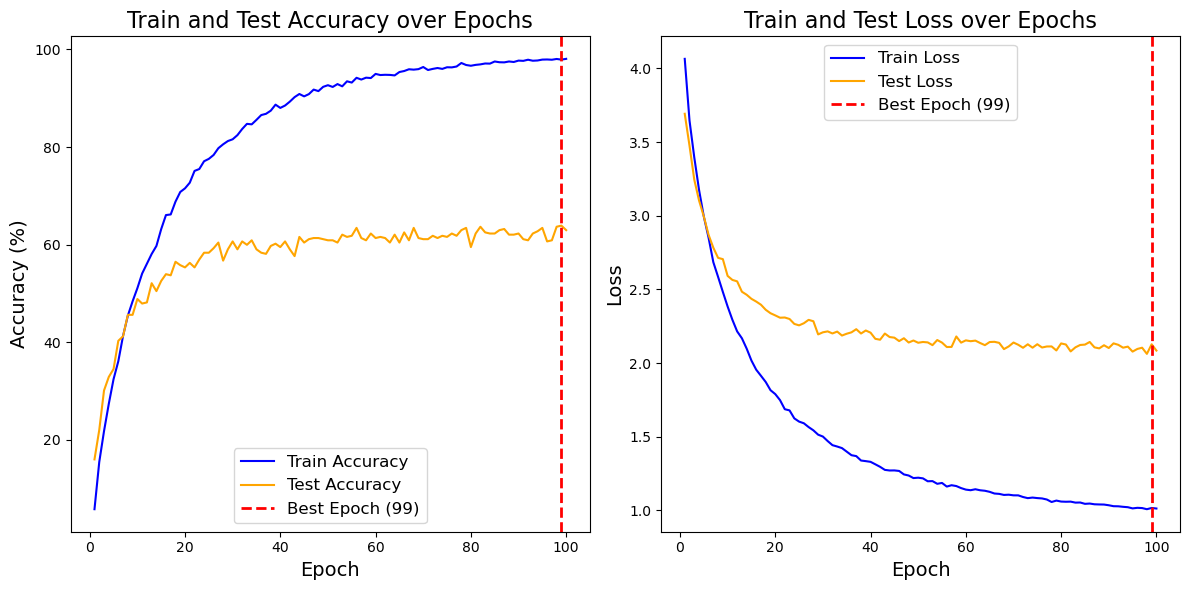

In [68]:
class DCT_Conv_CNN(nn.Module):
    def __init__(self):
        super(DCT_Conv_CNN, self).__init__()
        self.dct_conv1 = BlockToeplitzDCTLayer(n=128)
        self.dct_conv2 = BlockToeplitzDCTLayer(n=256)
        self.dct_conv3 = BlockToeplitzDCTLayer(n=512)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn = nn.BatchNorm1d(16384)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(16384, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc4 = nn.Linear(256, 60)

    def forward(self, x):
        x = F.relu(self.dct_conv1(x))
        x = F.relu(self.dct_conv2(x))
        x = self.pool1(F.relu(self.dct_conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.bn(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc4(x)

def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d, BlockToeplitzDCTLayer)):
        for param in m.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
            else:
                nn.init.zeros_(param)

model = DCT_Conv_CNN()
model.apply(init_weights)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)


train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []
import matplotlib.pyplot as plt

def plot_metrics():
    # Find the epoch with the highest test accuracy
    best_epoch = test_accuracies.index(max(test_accuracies)) + 1

    # Plot accuracies
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', color='orange')
    plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})', linewidth=2)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.title('Train and Test Accuracy over Epochs', fontsize=16)
    plt.legend(fontsize=12)

    # Plot losses
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', color='orange')
    plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})', linewidth=2)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Train and Test Loss over Epochs', fontsize=16)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

def train_network(device='cpu'):
    model.to(device)
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracies.append(100 * correct / total)
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        test_accuracies.append(100 * test_correct / test_total)
        test_losses.append(test_loss / len(test_loader))

        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")
        print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {100 * test_correct/test_total:.2f}%")
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    plot_metrics()
train_network(device='cpu')

In [ ]:
4 layers

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/100, Loss: 4.0493, Accuracy: 6.56%
Test Loss: 3.7464, Test Accuracy: 17.82%
Precision: 0.2428, Recall: 0.1782, F1 Score: 0.1572


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/100, Loss: 3.7309, Accuracy: 16.18%
Test Loss: 3.5629, Test Accuracy: 25.69%
Precision: 0.2987, Recall: 0.2569, F1 Score: 0.2262


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/100, Loss: 3.5095, Accuracy: 22.97%
Test Loss: 3.3942, Test Accuracy: 31.48%
Precision: 0.3951, Recall: 0.3148, F1 Score: 0.2869


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/100, Loss: 3.3410, Accuracy: 28.34%
Test Loss: 3.2696, Test Accuracy: 33.33%
Precision: 0.3804, Recall: 0.3333, F1 Score: 0.3140


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/100, Loss: 3.1912, Accuracy: 34.05%
Test Loss: 3.1992, Test Accuracy: 36.57%
Precision: 0.4307, Recall: 0.3657, F1 Score: 0.3518
Epoch 6/100, Loss: 3.0777, Accuracy: 38.09%
Test Loss: 3.1141, Test Accuracy: 42.82%
Precision: 0.4733, Recall: 0.4282, F1 Score: 0.4171


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/100, Loss: 2.9597, Accuracy: 43.00%
Test Loss: 3.0749, Test Accuracy: 40.97%
Precision: 0.4339, Recall: 0.4097, F1 Score: 0.3966


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/100, Loss: 2.8787, Accuracy: 47.20%
Test Loss: 3.0030, Test Accuracy: 44.68%
Precision: 0.4925, Recall: 0.4468, F1 Score: 0.4340
Epoch 9/100, Loss: 2.8068, Accuracy: 48.97%
Test Loss: 2.9677, Test Accuracy: 46.99%
Precision: 0.5426, Recall: 0.4699, F1 Score: 0.4654
Epoch 10/100, Loss: 2.7235, Accuracy: 53.60%
Test Loss: 2.9135, Test Accuracy: 47.69%
Precision: 0.5594, Recall: 0.4769, F1 Score: 0.4702
Epoch 11/100, Loss: 2.6512, Accuracy: 56.66%
Test Loss: 2.9004, Test Accuracy: 49.54%
Precision: 0.5602, Recall: 0.4954, F1 Score: 0.4818
Epoch 12/100, Loss: 2.5985, Accuracy: 58.28%
Test Loss: 2.8336, Test Accuracy: 53.70%
Precision: 0.5945, Recall: 0.5370, F1 Score: 0.5305
Epoch 13/100, Loss: 2.5464, Accuracy: 60.26%
Test Loss: 2.8338, Test Accuracy: 51.39%
Precision: 0.6023, Recall: 0.5139, F1 Score: 0.5100
Epoch 14/100, Loss: 2.4817, Accuracy: 63.58%
Test Loss: 2.7684, Test Accuracy: 53.70%
Precision: 0.5657, Recall: 0.5370, F1 Score: 0.5286
Epoch 15/100, Loss: 2.4455, Accuracy

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16/100, Loss: 2.3957, Accuracy: 66.44%
Test Loss: 2.7722, Test Accuracy: 52.55%
Precision: 0.5650, Recall: 0.5255, F1 Score: 0.5111
Epoch 17/100, Loss: 2.3627, Accuracy: 67.13%
Test Loss: 2.7300, Test Accuracy: 55.79%
Precision: 0.5869, Recall: 0.5579, F1 Score: 0.5434
Epoch 18/100, Loss: 2.3182, Accuracy: 69.37%
Test Loss: 2.7028, Test Accuracy: 57.64%
Precision: 0.6080, Recall: 0.5764, F1 Score: 0.5695
Epoch 19/100, Loss: 2.2998, Accuracy: 70.65%
Test Loss: 2.7396, Test Accuracy: 53.94%
Precision: 0.5896, Recall: 0.5394, F1 Score: 0.5374
Epoch 20/100, Loss: 2.2634, Accuracy: 72.87%
Test Loss: 2.6878, Test Accuracy: 57.41%
Precision: 0.6216, Recall: 0.5741, F1 Score: 0.5724
Epoch 21/100, Loss: 2.2226, Accuracy: 74.61%
Test Loss: 2.6875, Test Accuracy: 56.25%
Precision: 0.5968, Recall: 0.5625, F1 Score: 0.5572
Epoch 22/100, Loss: 2.1945, Accuracy: 76.00%
Test Loss: 2.6613, Test Accuracy: 57.18%
Precision: 0.6278, Recall: 0.5718, F1 Score: 0.5761


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 23/100, Loss: 2.1684, Accuracy: 76.75%
Test Loss: 2.6667, Test Accuracy: 59.72%
Precision: 0.6476, Recall: 0.5972, F1 Score: 0.5934
Epoch 24/100, Loss: 2.1486, Accuracy: 77.80%
Test Loss: 2.6768, Test Accuracy: 57.18%
Precision: 0.6206, Recall: 0.5718, F1 Score: 0.5623
Epoch 25/100, Loss: 2.1302, Accuracy: 78.96%
Test Loss: 2.6643, Test Accuracy: 58.33%
Precision: 0.6205, Recall: 0.5833, F1 Score: 0.5699
Epoch 26/100, Loss: 2.1037, Accuracy: 79.32%
Test Loss: 2.6415, Test Accuracy: 58.10%
Precision: 0.6078, Recall: 0.5810, F1 Score: 0.5695
Epoch 27/100, Loss: 2.0920, Accuracy: 80.58%
Test Loss: 2.6209, Test Accuracy: 57.87%
Precision: 0.6254, Recall: 0.5787, F1 Score: 0.5772
Epoch 28/100, Loss: 2.0517, Accuracy: 82.28%
Test Loss: 2.6227, Test Accuracy: 56.94%
Precision: 0.6253, Recall: 0.5694, F1 Score: 0.5670
Epoch 29/100, Loss: 2.0256, Accuracy: 83.54%
Test Loss: 2.6155, Test Accuracy: 58.10%
Precision: 0.6162, Recall: 0.5810, F1 Score: 0.5724
Epoch 30/100, Loss: 2.0156, Accura

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 32/100, Loss: 1.9974, Accuracy: 85.19%
Test Loss: 2.6271, Test Accuracy: 58.10%
Precision: 0.6179, Recall: 0.5810, F1 Score: 0.5768
Epoch 33/100, Loss: 1.9695, Accuracy: 86.73%
Test Loss: 2.6075, Test Accuracy: 56.48%
Precision: 0.6126, Recall: 0.5648, F1 Score: 0.5610
Epoch 34/100, Loss: 1.9628, Accuracy: 85.91%
Test Loss: 2.5958, Test Accuracy: 58.10%
Precision: 0.6183, Recall: 0.5810, F1 Score: 0.5772
Epoch 35/100, Loss: 1.9568, Accuracy: 86.65%
Test Loss: 2.5967, Test Accuracy: 57.87%
Precision: 0.6230, Recall: 0.5787, F1 Score: 0.5748
Epoch 36/100, Loss: 1.9411, Accuracy: 87.11%
Test Loss: 2.5742, Test Accuracy: 59.26%
Precision: 0.6203, Recall: 0.5926, F1 Score: 0.5912
Epoch 37/100, Loss: 1.9262, Accuracy: 87.99%
Test Loss: 2.5893, Test Accuracy: 58.56%
Precision: 0.6362, Recall: 0.5856, F1 Score: 0.5855
Epoch 38/100, Loss: 1.9106, Accuracy: 88.22%
Test Loss: 2.6025, Test Accuracy: 57.41%
Precision: 0.6175, Recall: 0.5741, F1 Score: 0.5705
Epoch 39/100, Loss: 1.8958, Accura

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 50/100, Loss: 1.8012, Accuracy: 92.54%
Test Loss: 2.5421, Test Accuracy: 62.04%
Precision: 0.6475, Recall: 0.6204, F1 Score: 0.6156
Epoch 51/100, Loss: 1.7961, Accuracy: 92.80%
Test Loss: 2.5469, Test Accuracy: 61.11%
Precision: 0.6558, Recall: 0.6111, F1 Score: 0.6132
Epoch 52/100, Loss: 1.7847, Accuracy: 93.72%
Test Loss: 2.5434, Test Accuracy: 59.49%
Precision: 0.6359, Recall: 0.5949, F1 Score: 0.5966
Epoch 53/100, Loss: 1.7772, Accuracy: 93.62%
Test Loss: 2.5440, Test Accuracy: 60.42%
Precision: 0.6571, Recall: 0.6042, F1 Score: 0.6010
Epoch 54/100, Loss: 1.7777, Accuracy: 93.93%
Test Loss: 2.5450, Test Accuracy: 60.42%
Precision: 0.6383, Recall: 0.6042, F1 Score: 0.6004
Epoch 55/100, Loss: 1.7654, Accuracy: 94.24%
Test Loss: 2.5667, Test Accuracy: 58.56%
Precision: 0.6410, Recall: 0.5856, F1 Score: 0.5919
Epoch 56/100, Loss: 1.7633, Accuracy: 93.57%
Test Loss: 2.5519, Test Accuracy: 60.42%
Precision: 0.6402, Recall: 0.6042, F1 Score: 0.6013
Epoch 57/100, Loss: 1.7569, Accura

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 58/100, Loss: 1.7538, Accuracy: 94.98%
Test Loss: 2.5434, Test Accuracy: 60.65%
Precision: 0.6457, Recall: 0.6065, F1 Score: 0.6056
Epoch 59/100, Loss: 1.7410, Accuracy: 94.91%
Test Loss: 2.5262, Test Accuracy: 60.42%
Precision: 0.6384, Recall: 0.6042, F1 Score: 0.6005
Epoch 60/100, Loss: 1.7402, Accuracy: 94.80%
Test Loss: 2.5418, Test Accuracy: 59.95%
Precision: 0.6715, Recall: 0.5995, F1 Score: 0.6028
Epoch 61/100, Loss: 1.7308, Accuracy: 95.29%
Test Loss: 2.5222, Test Accuracy: 60.19%
Precision: 0.6395, Recall: 0.6019, F1 Score: 0.5996
Epoch 62/100, Loss: 1.7382, Accuracy: 94.88%
Test Loss: 2.5352, Test Accuracy: 61.81%
Precision: 0.6501, Recall: 0.6181, F1 Score: 0.6157
Epoch 63/100, Loss: 1.7281, Accuracy: 95.01%
Test Loss: 2.5149, Test Accuracy: 62.50%
Precision: 0.6751, Recall: 0.6250, F1 Score: 0.6239
Epoch 64/100, Loss: 1.7145, Accuracy: 95.52%
Test Loss: 2.5017, Test Accuracy: 61.11%
Precision: 0.6660, Recall: 0.6111, F1 Score: 0.6111
Epoch 65/100, Loss: 1.7152, Accura

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


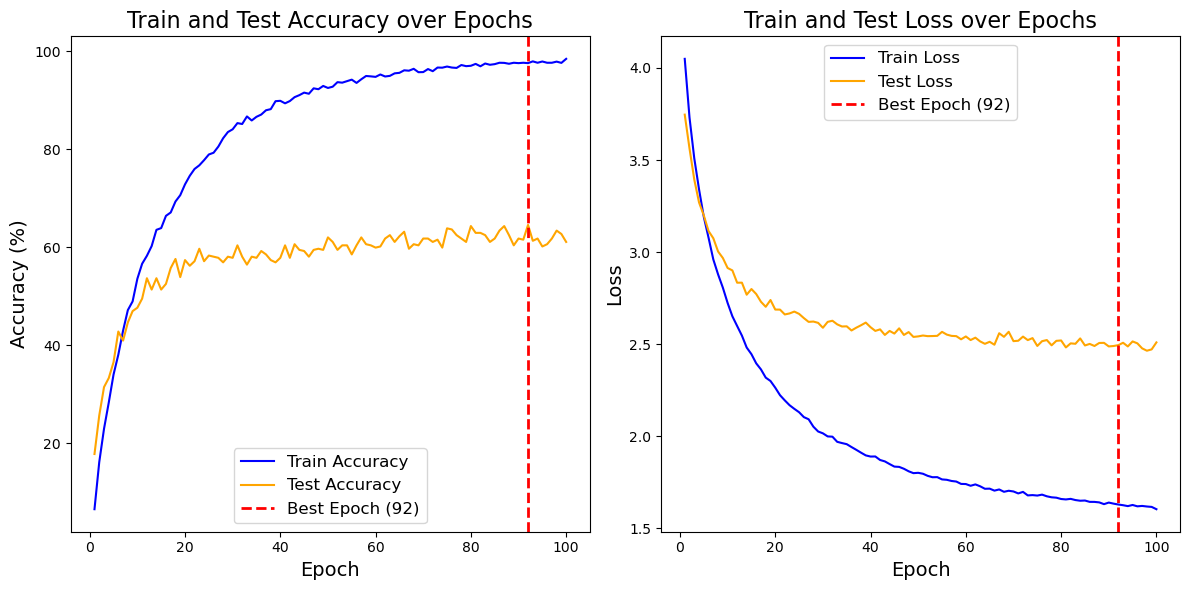

In [77]:

class DCT_Conv_CNN(nn.Module):
    def __init__(self):
        super(DCT_Conv_CNN, self).__init__()
        self.dct_conv1 = BlockToeplitzDCTLayer(n=128)
        self.dct_conv2 = BlockToeplitzDCTLayer(n=256)
        self.dct_conv3 = BlockToeplitzDCTLayer(n=512)
        self.dct_conv4 = BlockToeplitzDCTLayer(n=1024)
        self.pool1 = nn.MaxPool2d(2, 2)  # Only one pooling layer
        self.bn = nn.BatchNorm1d(32768)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32768, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc4 = nn.Linear(256, 60)

    def forward(self, x):
        x = F.relu(self.dct_conv1(x)) # Apply the pooling after the first DCT layer
        x = F.relu(self.dct_conv2(x))
        x = F.relu(self.dct_conv3(x))
        x = self.pool1(F.relu(self.dct_conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.bn(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc4(x)

def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d, BlockToeplitzDCTLayer)):
        for param in m.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
            else:
                nn.init.zeros_(param)

model = DCT_Conv_CNN()
model.apply(init_weights)

criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)


train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []
import matplotlib.pyplot as plt

def plot_metrics():
    # Find the epoch with the highest test accuracy
    best_epoch = test_accuracies.index(max(test_accuracies)) + 1

    # Plot accuracies
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', color='orange')
    plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})', linewidth=2)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.title('Train and Test Accuracy over Epochs', fontsize=16)
    plt.legend(fontsize=12)

    # Plot losses
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', color='orange')
    plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})', linewidth=2)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Train and Test Loss over Epochs', fontsize=16)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

def train_network(device='cpu'):
    model.to(device)
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracies.append(100 * correct / total)
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        test_accuracies.append(100 * test_correct / test_total)
        test_losses.append(test_loss / len(test_loader))

        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")
        print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {100 * test_correct/test_total:.2f}%")
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    plot_metrics()
train_network(device='cpu')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/100, Loss: 3.9716, Accuracy: 6.89%
Test Loss: 3.6702, Test Accuracy: 14.81%
Precision: 0.1563, Recall: 0.1481, F1 Score: 0.1117


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/100, Loss: 3.6108, Accuracy: 16.20%
Test Loss: 3.3886, Test Accuracy: 24.31%
Precision: 0.2342, Recall: 0.2431, F1 Score: 0.2075


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/100, Loss: 3.3430, Accuracy: 23.79%
Test Loss: 3.1933, Test Accuracy: 29.63%
Precision: 0.3142, Recall: 0.2963, F1 Score: 0.2709


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/100, Loss: 3.1185, Accuracy: 29.73%
Test Loss: 3.0560, Test Accuracy: 34.03%
Precision: 0.4086, Recall: 0.3403, F1 Score: 0.3214


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/100, Loss: 2.9452, Accuracy: 35.16%
Test Loss: 2.9003, Test Accuracy: 38.66%
Precision: 0.4308, Recall: 0.3866, F1 Score: 0.3680


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/100, Loss: 2.7929, Accuracy: 39.33%
Test Loss: 2.8172, Test Accuracy: 40.74%
Precision: 0.5159, Recall: 0.4074, F1 Score: 0.4064
Epoch 7/100, Loss: 2.6653, Accuracy: 41.98%
Test Loss: 2.7267, Test Accuracy: 44.21%
Precision: 0.5148, Recall: 0.4421, F1 Score: 0.4339


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/100, Loss: 2.5434, Accuracy: 45.52%
Test Loss: 2.6563, Test Accuracy: 44.44%
Precision: 0.4908, Recall: 0.4444, F1 Score: 0.4279
Epoch 9/100, Loss: 2.4249, Accuracy: 49.87%
Test Loss: 2.5973, Test Accuracy: 47.69%
Precision: 0.5085, Recall: 0.4769, F1 Score: 0.4619
Epoch 10/100, Loss: 2.3248, Accuracy: 53.09%
Test Loss: 2.5479, Test Accuracy: 48.61%
Precision: 0.5639, Recall: 0.4861, F1 Score: 0.4778
Epoch 11/100, Loss: 2.2473, Accuracy: 55.43%
Test Loss: 2.5248, Test Accuracy: 51.16%
Precision: 0.5942, Recall: 0.5116, F1 Score: 0.5019
Epoch 12/100, Loss: 2.1820, Accuracy: 57.92%
Test Loss: 2.4527, Test Accuracy: 51.62%
Precision: 0.5833, Recall: 0.5162, F1 Score: 0.5113
Epoch 13/100, Loss: 2.1155, Accuracy: 60.78%
Test Loss: 2.3866, Test Accuracy: 50.93%
Precision: 0.5575, Recall: 0.5093, F1 Score: 0.4957
Epoch 14/100, Loss: 2.0523, Accuracy: 62.19%
Test Loss: 2.4046, Test Accuracy: 52.31%
Precision: 0.5986, Recall: 0.5231, F1 Score: 0.5132
Epoch 15/100, Loss: 1.9901, Accuracy

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 26/100, Loss: 1.5681, Accuracy: 79.94%
Test Loss: 2.1722, Test Accuracy: 59.03%
Precision: 0.6142, Recall: 0.5903, F1 Score: 0.5812
Epoch 27/100, Loss: 1.5197, Accuracy: 81.61%
Test Loss: 2.2055, Test Accuracy: 58.10%
Precision: 0.6318, Recall: 0.5810, F1 Score: 0.5794
Epoch 28/100, Loss: 1.5256, Accuracy: 80.56%
Test Loss: 2.1666, Test Accuracy: 59.72%
Precision: 0.6428, Recall: 0.5972, F1 Score: 0.5951
Epoch 29/100, Loss: 1.4745, Accuracy: 82.95%
Test Loss: 2.1883, Test Accuracy: 59.49%
Precision: 0.6545, Recall: 0.5949, F1 Score: 0.5994


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 30/100, Loss: 1.4777, Accuracy: 82.92%
Test Loss: 2.1567, Test Accuracy: 59.95%
Precision: 0.6402, Recall: 0.5995, F1 Score: 0.5965
Epoch 31/100, Loss: 1.4431, Accuracy: 84.08%
Test Loss: 2.1694, Test Accuracy: 59.26%
Precision: 0.6553, Recall: 0.5926, F1 Score: 0.5929
Epoch 32/100, Loss: 1.4362, Accuracy: 84.65%
Test Loss: 2.1441, Test Accuracy: 59.95%
Precision: 0.6358, Recall: 0.5995, F1 Score: 0.5967


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 33/100, Loss: 1.4015, Accuracy: 85.93%
Test Loss: 2.1842, Test Accuracy: 59.95%
Precision: 0.6478, Recall: 0.5995, F1 Score: 0.5995
Epoch 34/100, Loss: 1.3924, Accuracy: 86.34%
Test Loss: 2.0891, Test Accuracy: 59.95%
Precision: 0.6355, Recall: 0.5995, F1 Score: 0.5971
Epoch 35/100, Loss: 1.3633, Accuracy: 87.22%
Test Loss: 2.1396, Test Accuracy: 59.95%
Precision: 0.6442, Recall: 0.5995, F1 Score: 0.5995


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 36/100, Loss: 1.3784, Accuracy: 86.65%
Test Loss: 2.1206, Test Accuracy: 62.04%
Precision: 0.6491, Recall: 0.6204, F1 Score: 0.6168
Epoch 37/100, Loss: 1.3542, Accuracy: 87.40%
Test Loss: 2.1386, Test Accuracy: 60.42%
Precision: 0.6550, Recall: 0.6042, F1 Score: 0.6060
Epoch 38/100, Loss: 1.3336, Accuracy: 88.09%
Test Loss: 2.1016, Test Accuracy: 62.73%
Precision: 0.6737, Recall: 0.6273, F1 Score: 0.6313
Epoch 39/100, Loss: 1.3352, Accuracy: 88.48%
Test Loss: 2.1776, Test Accuracy: 59.26%
Precision: 0.6348, Recall: 0.5926, F1 Score: 0.5914
Epoch 40/100, Loss: 1.3069, Accuracy: 89.20%
Test Loss: 2.1253, Test Accuracy: 60.42%
Precision: 0.6602, Recall: 0.6042, F1 Score: 0.6014
Epoch 41/100, Loss: 1.3075, Accuracy: 89.35%
Test Loss: 2.1297, Test Accuracy: 59.49%
Precision: 0.6609, Recall: 0.5949, F1 Score: 0.5992


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 42/100, Loss: 1.2755, Accuracy: 90.53%
Test Loss: 2.1005, Test Accuracy: 62.04%
Precision: 0.6633, Recall: 0.6204, F1 Score: 0.6226


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 43/100, Loss: 1.2779, Accuracy: 90.25%
Test Loss: 2.1689, Test Accuracy: 58.10%
Precision: 0.6284, Recall: 0.5810, F1 Score: 0.5760
Epoch 44/100, Loss: 1.2708, Accuracy: 90.35%
Test Loss: 2.1105, Test Accuracy: 62.27%
Precision: 0.6632, Recall: 0.6227, F1 Score: 0.6245


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 45/100, Loss: 1.2747, Accuracy: 90.90%
Test Loss: 2.1043, Test Accuracy: 60.88%
Precision: 0.6605, Recall: 0.6088, F1 Score: 0.6081
Epoch 46/100, Loss: 1.2442, Accuracy: 91.72%
Test Loss: 2.1086, Test Accuracy: 61.11%
Precision: 0.6525, Recall: 0.6111, F1 Score: 0.6125
Epoch 47/100, Loss: 1.2315, Accuracy: 92.18%
Test Loss: 2.0938, Test Accuracy: 62.04%
Precision: 0.6920, Recall: 0.6204, F1 Score: 0.6252
Epoch 48/100, Loss: 1.2350, Accuracy: 91.74%
Test Loss: 2.1369, Test Accuracy: 60.42%
Precision: 0.6395, Recall: 0.6042, F1 Score: 0.5996
Epoch 49/100, Loss: 1.2199, Accuracy: 92.13%
Test Loss: 2.1289, Test Accuracy: 61.81%
Precision: 0.6720, Recall: 0.6181, F1 Score: 0.6209
Epoch 50/100, Loss: 1.2074, Accuracy: 93.03%
Test Loss: 2.1183, Test Accuracy: 60.19%
Precision: 0.6414, Recall: 0.6019, F1 Score: 0.5995
Epoch 51/100, Loss: 1.1990, Accuracy: 92.90%
Test Loss: 2.1292, Test Accuracy: 60.65%
Precision: 0.6456, Recall: 0.6065, F1 Score: 0.6075
Epoch 52/100, Loss: 1.2014, Accura

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 57/100, Loss: 1.1670, Accuracy: 94.26%
Test Loss: 2.1386, Test Accuracy: 61.11%
Precision: 0.6706, Recall: 0.6111, F1 Score: 0.6147
Epoch 58/100, Loss: 1.1521, Accuracy: 94.52%
Test Loss: 2.1302, Test Accuracy: 62.04%
Precision: 0.6969, Recall: 0.6204, F1 Score: 0.6260
Epoch 59/100, Loss: 1.1505, Accuracy: 94.98%
Test Loss: 2.1174, Test Accuracy: 62.04%
Precision: 0.6766, Recall: 0.6204, F1 Score: 0.6180
Epoch 60/100, Loss: 1.1402, Accuracy: 95.04%
Test Loss: 2.1039, Test Accuracy: 62.73%
Precision: 0.6932, Recall: 0.6273, F1 Score: 0.6342
Epoch 61/100, Loss: 1.1310, Accuracy: 95.24%
Test Loss: 2.0941, Test Accuracy: 62.96%
Precision: 0.6708, Recall: 0.6296, F1 Score: 0.6251
Epoch 62/100, Loss: 1.1368, Accuracy: 94.80%
Test Loss: 2.0819, Test Accuracy: 61.34%
Precision: 0.6693, Recall: 0.6134, F1 Score: 0.6200
Epoch 63/100, Loss: 1.1320, Accuracy: 94.83%
Test Loss: 2.0842, Test Accuracy: 62.50%
Precision: 0.6882, Recall: 0.6250, F1 Score: 0.6323
Epoch 64/100, Loss: 1.1323, Accura

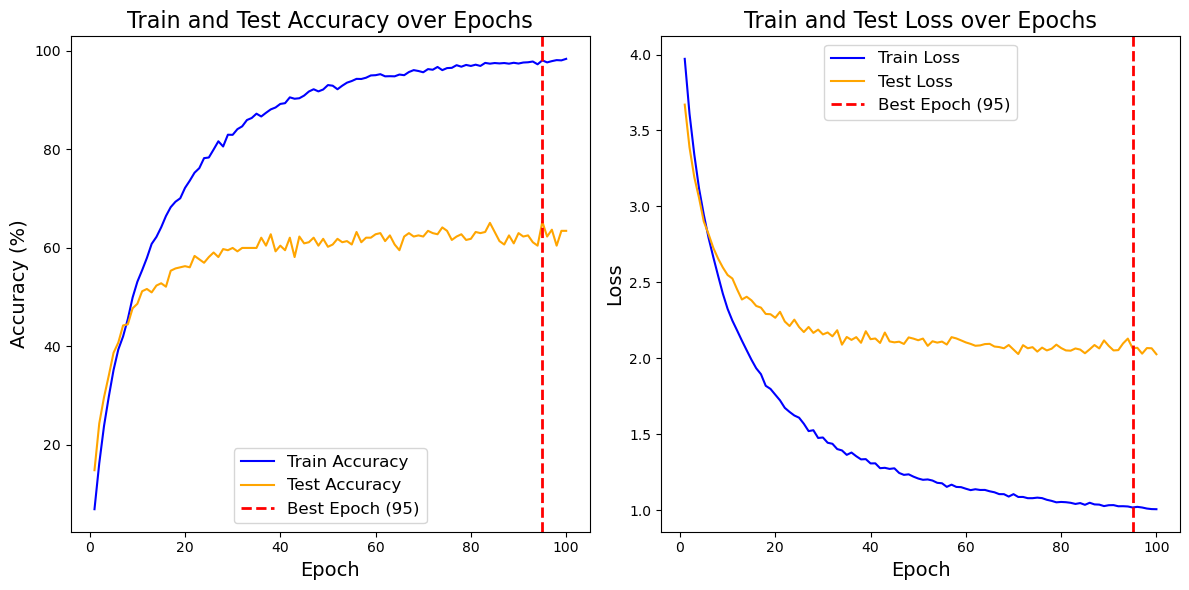

In [70]:
class DCT_Conv_CNN(nn.Module):
    def __init__(self):
        super(DCT_Conv_CNN, self).__init__()
        self.dct_conv1 = BlockToeplitzDCTLayer(n=128)
        self.dct_conv2 = BlockToeplitzDCTLayer(n=256)
        self.dct_conv3 = BlockToeplitzDCTLayer(n=512)
        self.dct_conv4 = BlockToeplitzDCTLayer(n=1024)
        self.dct_conv5 = BlockToeplitzDCTLayer(n=2048)
        self.pool1 = nn.MaxPool2d(2, 2)  # Only one pooling layer
        self.bn = nn.BatchNorm1d(65536)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(65536, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc4 = nn.Linear(256, 60)

    def forward(self, x):
        x = F.relu(self.dct_conv1(x)) # Apply the pooling after the first DCT layer
        x = F.relu(self.dct_conv2(x))
        x = F.relu(self.dct_conv3(x))
        x = F.relu(self.dct_conv4(x))
        x = self.pool1(F.relu(self.dct_conv5(x)))
        x = x.view(x.size(0), -1)
        x = self.bn(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc4(x)

def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d, BlockToeplitzDCTLayer)):
        for param in m.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
            else:
                nn.init.zeros_(param)

model = DCT_Conv_CNN()
model.apply(init_weights)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)


train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []
import matplotlib.pyplot as plt

def plot_metrics():
    # Find the epoch with the highest test accuracy
    best_epoch = test_accuracies.index(max(test_accuracies)) + 1

    # Plot accuracies
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', color='orange')
    plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})', linewidth=2)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.title('Train and Test Accuracy over Epochs', fontsize=16)
    plt.legend(fontsize=12)

    # Plot losses
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', color='orange')
    plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})', linewidth=2)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Train and Test Loss over Epochs', fontsize=16)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

def train_network(device='cpu'):
    model.to(device)
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracies.append(100 * correct / total)
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        test_accuracies.append(100 * test_correct / test_total)
        test_losses.append(test_loss / len(test_loader))

        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")
        print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {100 * test_correct/test_total:.2f}%")
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    plot_metrics()
train_network(device='cpu')